# Introduction

Let's learn about modeling fitting with RL!

In this tutorial, we will learn about:

* Implementing an RL environment
* Implementing an RL agent
* Fitting data to RL models
* Model Comparison and validation

Author: Alana Jaskir, https://github.com/amjaskir

In [ ]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import random
import datetime
from scipy.optimize import minimize

To define different components of our simulation, we will make use of [object oriented programming (OOP)](https://realpython.com/python3-object-oriented-programming/). OOP is helpful because it lets us define general classes we can reuse across different simulations to create new instances of each component (e.g. different instances of an agent, environment, etc).

Helpful links:

* [Python 101 Google Colab notebook](https://colab.research.google.com/drive/1RgQqcpMyfU8FOZDgIARLqhvpKaefUMnO?usp=sharing)
* [The Python Tutorial](https://docs.python.org/3/tutorial/index.html)
* [Mathesaurus](http://mathesaurus.sourceforge.net/)


# Multi-armed bandits





## Defining the environment

The below code flexibly creates an environment with actions or "arms" (k).

When selecting a given arm, reward will be administered according to a normal distribution with a specified mean (mu) and standard devidation (sigma).

Environment code adapted from [this course](https://github.com/Center-for-Computational-Psychiatry/course_fcp?tab=readme-ov-file).

In [ ]:
class Environment(object):

  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms.
  mu : array, float, shape(k, )
      Mean for each arm.
  sigma : array, float, shape(k, )
      Standard deviation for each arm.

  """

  def __init__(self, k, mu, sigma):

    """Constructor for the Environment class
    This function runs every time we create an instance of the class Environment
    To learn more about how constructors work: https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html"""

    # "self" is just a convention that binds the attributes and methods of a class with the arguments of a given instance

    self.k = k          # number of arms
    self.mu = mu        # mean of reward distribution for each arm
    self.sigma = sigma  # standard deviation of reward distribution for each arm

    if self.mu.shape[0] is not k:
      raise Warning("Mean vector shape does not match number of arms")

    if self.sigma.shape[0] is not k:
      raise Warning("Sigma vector shape does not match number of arms")

  def visualize(self, style):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case, this consists of the reward distribution for each arm

    # visualize as Gaussian densities
    if style == 1:

      x = np.arange(-5, 5, 0.001)

      for i in np.arange(self.k):
        plt.plot(x, norm.pdf(x, self.mu[i], self.sigma[i]), label=f'A{i+1} μ: ' + str(self.mu[i]) + ', σ: ' + str(self.sigma[i]))

      plt.legend()
      plt.xlabel('Reward distribution')
      plt.ylabel('Density')

    # draw many samples from each distribution and plot histograms
    if style == 2:

      # initialize output list
      bandit = []   # which bandit we're drawing from
      samples = []  # samples we drew

      # iterate over each bandit
      for i in np.arange(self.k):

        n_samples = 1000

        # create bandit index
        b = list(np.ones((n_samples, )) * (i+1))

        # draw samples
        s = list(np.random.normal(self.mu[i], self.sigma[i], n_samples))

        # add to lists
        bandit = bandit + b
        samples = samples + s

      # create pandas dataframe from dictionary
      # background on dictionaries: https://www.w3schools.com/python/python_dictionaries.asp
      # background on dataframes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
      df = pd.DataFrame({'bandit': list(map(int, bandit)),
                         'samples': samples})

      # use seaborn to plot distributions
      # background on seaborn: https://seaborn.pydata.org/index.html
      sns.violinplot(data=df, x="bandit", y="samples", hue="bandit", palette="deep", legend=False)

      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    reward = np.random.normal(self.mu[action-1], self.sigma[action-1], 1)[0]

    return reward


In [ ]:
# Initialize a 10-armed bandit where each arm has an increasing mean and standard deviation of 1
n_arms = 10
means = np.arange(n_arms)-5
sds = np.ones((n_arms,))

# This line creates an instance of the class we defined above with some attributes
env_example = Environment(n_arms, means, sds)

In [ ]:
# Visualize
# Note how now we can access the method inside the class for this specific instance
env_example.visualize(1)

In [ ]:
env_example.visualize(2)

In [ ]:
# Draw rewards for each action
for a in np.arange(10):
  action = a + 1
  print('took action: ' + str(action))
  print('reward received: ' + str(env_example.step(action)))

### **EXERCISE**

In the coding blocks below, create a new environment "env_twoarm" with two arms:


*   Arm 1: mean = -1, mu = 1
*   Arm 2: mean = 1, mu = 1




In [ ]:
# TODO: Define new environment
# Numpy HINT: np.array([.1,.2,.3,.4]) makes an array with the specified values

env_twoarm = "TODO"

In [ ]:
# TODO: visualize the new environment


In [ ]:
# IF YOU NEED HELP (BUT TRY YOURSELF FIRST!)




















n_arms = 2
means = np.array([-1,1])
sds = np.ones((2,))

env_twoarm = Environment(n_arms, means, sds)

# visualize 1
env_twoarm.visualize(1)
plt.figure() # make sure second plot is a new figure
env_twoarm.visualize(2)

### **DISCUSSION**

In this environment, rewards are 1) normally distributed for each action and 2) have the same standard deviation.

How else might reward be structured?

How could you modify the Environment class above accordingly?

#### Example:

In [ ]:
class EnvironmentBinomial(object):

  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms.
  prob : array, float, shape(k, )
      Probability for each arm.

  """

  def __init__(self, k, prob):                                              # ------------------------------------ UPDATED

    """Constructor for the Environment class
    This function runs every time we create an instance of the class Environment
    To learn more about how constructors work: https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html"""

    # "self" is just a convention that binds the attributes and methods of a class with the arguments of a given instance

    self.k = k            # number of arms
    self.prob = prob        # mean of reward distribution for each arm      # ------------------------------------ UPDATED

    if self.prob.shape[0] is not k:
      raise Warning("Prob vector shape does not match number of arms")      # ------------------------------------ UPDATED

  def visualize(self, style):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case

    # visualize as Reward probabilities
    if style == 1:

      for i in np.arange(self.k):
        plt.bar(i, self.prob[i], label='P: ' + str(self.prob[i]))      # ------------------------------------ UPDATED

      plt.xlabel('Arm')
      plt.ylabel('Reward probability')

    # draw many samples from each distribution and plot histograms
    if style == 2:

      # initialize output list
      bandit = []   # which bandit we're drawing from
      samples = []  # samples we drew

      # iterate over each bandit
      for i in np.arange(self.k):

        n_samples = 1000

        # create bandit index
        b = list(np.ones((n_samples, )) * (i+1))

        # draw samples
        s = list(np.random.binomial(1, self.prob[i], n_samples))   # ------------------------------------ UPDATED

        # add to lists
        bandit = bandit + b
        samples = samples + s

      # create pandas dataframe from dictionary
      # background on dictionaries: https://www.w3schools.com/python/python_dictionaries.asp
      # background on dataframes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
      df = pd.DataFrame({'bandit': list(map(int, bandit)),
                         'samples': samples})

      # use seaborn to plot distributions
      # background on seaborn: https://seaborn.pydata.org/index.html
      sns.violinplot(data=df, x="bandit", y="samples", hue="bandit", palette="deep", legend=False)

      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    reward = np.random.binomial(1, self.prob[action-1], 1)[0]               # ------------------------------------ UPDATED

    return reward


In [ ]:
# Initialize a 10-armed bandit where each arm has an increasing mean and standard deviation of 1
n_arms = 10
probs = np.linspace(0.1, 1, n_arms)

# This line creates an instance of the class we defined above with some attributes
env_binomial_example = EnvironmentBinomial(n_arms, probs)

In [ ]:
print(probs)

In [ ]:
# Draw rewards for each action
for a in np.arange(10):
  action = a + 1
  print('took action: ' + str(action))
  print('reward received: ' + str(env_binomial_example.step(action)))

In [ ]:
env_binomial_example.visualize(1)

In [ ]:
env_binomial_example.visualize(2)

## Defining the Agent

### DISCUSSION

What are properties of an agent that we want to specify?

As the agent learns, what experiences should we track/remember?

### Agent Class: Outline



In [ ]:
class Agent(object):
  """Agent class

  Parameters
  ----------
  alpha : float, range (0, 1)
      learning rate
  beta  : float, range (0,inf)
      softmax temperature

  """

  def __init__(self, env, alpha, beta, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1

    # initialize parameters
    self.alpha = alpha
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.choice = np.nan
    self.reward = np.nan
    self.RPE = np.nan

  def policy(self):

    ''' TODO '''

    pass

  def update(self):

    ''' TODO '''

    pass

### Choice

#### Softmax

A common way of converting values into actions is using the **softmax function**.

* The softmax function takes the Q values of different actions and transforms them into a probability of selecting each action according to their relative values. The higher the value, the more likely the action will be taken.

* The softmax function can be adjusted with the parameter $\beta$, which controls how sensitive choice is to these differences.

---

Let's consider a two-armed bandit.

The probability of choosing action A would be:

$$ P(A) = \frac{e^{\beta * Q(A)}}{e^{\beta * Q(A)} + e^{\beta * Q(B)}}  = \frac{e^{\beta * Q(A)}}{Z}$$

The probability of choosing action B would be:

$$ P(B) = \frac{e^{\beta * Q(B)}}{e^{\beta * Q(A)} + e^{\beta * Q(B)}} = \frac{e^{\beta * Q(B)}}{Z} $$

where

$$Z = e^{\beta * Q(A)} + e^{\beta * Q(B)}$$


Notably, the denominator for both equations is the same (and this holds true for more than two actions). This normalizes the probabilities between 0 and 1 and ensures that:

$$\sum_{i \in Actions} P(i) = 1 $$

like a proper probability distribution. (A sanity check to ensure your softmax is implemented correctly is to sum the actions and ensure they equal 1.)

---

Using numpy, we can calculate the $P(A)$ and the $P(B)$ simultaneously. The below function also accomodates more than two actions.

In [ ]:
# Define softmax function
softmax = lambda Q, beta: np.exp(beta * Q) / sum(np.exp(beta * Q))

Q = np.array([1,-1])    # example Q values
beta = 1                # example beta
probs = softmax(Q,beta)
print(probs)


It's also helpful to think about the shape of the exponential function and how it interacts with $\beta$ to get intuition for how this translates to reward probabilities:

In [ ]:
# Define the Qs and betas
beta = 1
Q = np.array([1, -1])
x = np.linspace(-3, 3, 400)
y = np.exp(beta*x)

# Plot numerator
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(x, y, color='grey')

for idx, q in enumerate(Q):
  ax1.scatter(q, np.exp(q*beta), label = f'Action {idx + 1}', s=250)

ax1.set_xlabel('Q')
ax1.set_ylabel(r'$e^{\beta * Q}$')
ax1.set_title('Softmax numerator')
ax1.grid(True)
ax1.set_ylim(-1, 20)
ax1.legend()

# Plot probabilities
nactions = len(Q)
labels = np.array([f"Action {i+1}" for i in np.arange(nactions)])
probs = softmax(Q,beta)
ax2.pie(probs, labels=labels, autopct='%1.1f%%', startangle=140)
ax2.set_title('Action Probabilities')

plt.show()

#### EXERCISE: The Softmax Function

1.   What is the probability of selecting actions A and B when $\beta = 0$? Why? See if you can think of this in terms of the equations above.

2.   What is the probability of selecting actions A and B when $\beta = 3$?

3. Reset $\beta = 1$. Add another action with Q = 0. How does this change the action probabilities?

4. With your three Q values, increase $\beta = 2$, then $\beta = 3$, then $\beta = 4$. How does increasing $\beta$ change the curve on the left? How does this change correspond to the action probabilities on the right?

5. Reset $\beta = 1$. Set $Q = [-2, -1]$. Observe the action probabilities. Now set $Q = [2, 1]$. Observe the action probabilities. Are the action probabilities the same or different?



#### Let's implement this in the code:

In [ ]:
# TODO: FILL IN THE POLICY FUNCTION

class Agent(object):
  """Agent class

  Parameters
  ----------
  alpha : float, range (0, 1)
      learning rate
  beta  : float, range (0,inf)
      softmax temperature

  """

  def __init__(self, env, alpha, beta, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1

    # initialize parameters
    self.alpha = alpha
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.choice = np.nan
    self.reward = np.nan
    self.RPE = np.nan


  def policy(self):

    ''' TODO '''

    pass

  def update(self):

    ''' TODO '''

    pass

In [ ]:
# IF YOU WANT HELP (BUT TRY YOURSELF FIRST!)

class AgentSolution(object):
  """Agent class

  Parameters
  ----------
  alpha : float, range (0, 1)
      learning rate
  beta  : float, range (0,inf)
      softmax temperature

  """

  def __init__(self, env, alpha, beta, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1
    self.nactions = env.k

    # initialize parameters
    self.alpha = alpha
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.choice = np.nan
    self.reward = np.nan
    self.RPE = np.nan


  def policy(self):

    action_probs = np.exp(self.beta * self.q) / sum(np.exp(self.beta * self.q)) #softmax
    sampled_action = np.random.choice(self.nactions, p=action_probs) + 1 # actions are 1-indexed

    # log
    self.softmax_prob = action_probs
    self.choice = sampled_action

  def update(self):

    ''' TODO '''

    pass

### Updating

Recall:

*   How do we calculate a reward prediction-error?
*   How do we update our value?



In [ ]:
# TODO: FILL IN THE UPDATE FUNCTION

class Agent(object):
  """Agent class

  Parameters
  ----------
  alpha : float, range (0, 1)
      learning rate
  beta  : float, range (0,inf)
      softmax temperature

  """

  def __init__(self, env, alpha, beta, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1
    self.nactions = env.k

    # initialize parameters
    self.alpha = alpha
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.action = np.nan
    self.reward = np.nan
    self.RPE = np.nan


  def policy(self):

    action_probs = np.exp(self.beta * self.q) / sum(np.exp(self.beta * self.q)) #softmax
    sampled_action = np.random.choice(self.nactions, p=action_probs) + 1  # actions are 1-indexed

    # log
    self.softmax_prob = action_probs
    self.action = sampled_action

  def update(self, reward):

    ''' TODO '''

    pass

### Final Agent

In [ ]:
# IF YOU WANT HELP (BUT TRY YOURSELF FIRST!)

class AgentSolution(object):
  """Agent class

  Parameters
  ----------
  alpha : float, range (0, 1)
      learning rate
  beta  : float, range (0,inf)
      softmax temperature

  """

  def __init__(self, env, alpha, beta, q_init=False):
    ''' Initialize our learner '''

    # initialize action space
    self.action_space = np.arange(env.k) + 1
    self.nactions = env.k

    # initialize parameters
    self.alpha = alpha
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.action = np.nan
    self.reward = np.nan
    self.RPE = np.nan


  def policy(self):
    ''' Generate a choice according to q-values using the
    softmax function '''

    action_probs = np.exp(self.beta * self.q) / sum(np.exp(self.beta * self.q)) #softmax
    sampled_action = np.random.choice(self.nactions, p=action_probs) + 1

    # track
    self.softmax_prob = action_probs
    self.action = sampled_action

  def update(self, reward):
    ''' Update q-value of chosen action according to feedback '''

    action_idx = self.action - 1
    cur_val = self.q[action_idx]

    # track
    self.reward = reward
    self.RPE = reward - cur_val

    # update
    self.q[action_idx] = cur_val + self.alpha*self.RPE



## Simulating Agent in the Environment

Okay, great, let's put this all together!

We will now simulate our agent in our two-armed bandi environment for the desired number of trials. We will have a logger that keeps track of the actions and rewards of our agent, as well as the corresponding probability of each action according to the model.

Feel free to swap in your "Agent" class for the "AgentSolution" class to test your implementation!

In [ ]:
class LearningLog(object):

  def __init__(self, env, agent, ntrials):
    self.ntrials = ntrials
    self.nactions = env.k
    self.agent = agent
    self.env = env

    # choice log
    self.choice_history = pd.DataFrame(columns = ["Trial", "Action", "Probability", "Reward"])

    # q log
    col_names = np.array([f"Q{i+1}" for i in np.arange(self.nactions)])
    self.q_history = pd.DataFrame(columns = col_names)
    q_row = {}  # intialize with starting q values
    for q in np.arange(self.nactions):
      str_key = f'Q{q+1}'
      q_row[str_key] = self.agent.q[q]
    self.q_history.loc[len(self.q_history)] = q_row

  def run_simulation(self):

    # run for the specified number of trials
    for t in np.arange(self.ntrials):

      self.agent.policy()
      action = self.agent.action
      reward = self.env.step(action)
      self.agent.update(reward)

      # update choice log
      choice_row = {'Trial': t + 1,
             'Action':  action,
             'Probability':   self.agent.softmax_prob[action - 1],
             'Reward': reward}
      self.choice_history.loc[len(self.choice_history)] = choice_row

      # update q log
      q_row = {}
      for q in np.arange(self.nactions):
        str_key = f'Q{q+1}'
        q_row[str_key] = self.agent.q[q]
      self.q_history.loc[len(self.q_history)] = q_row

  def plot_choice_history(self):

    df = self.choice_history

    plt.figure(figsize=(5, 3))
    plt.scatter(df['Trial'], df['Action'], s = 100, color = "black")
    plt.title(f'Learning rate: {self.agent.alpha}  Softmax Temp: {self.agent.beta}')
    plt.xlabel('Trial')
    plt.ylabel('Action')
    plt.show()

  def plot_q_history(self):
    df = self.q_history
    colnames = df.columns

    plt.figure(figsize=(5, 3))
    for c in enumerate(colnames):
      c_str = c[1]
      plt.plot(np.array(df.index), df[c_str], label = c_str, linewidth = 3)

    plt.title(f'Learning rate: {self.agent.alpha}  Softmax Temp: {self.agent.beta}')
    plt.xlabel('Trial')
    plt.ylabel('QValue')
    plt.legend()
    plt.show()

In [ ]:
# let's initialize the logger
alpha = .1
beta = 1
ntrials = 50
test_agent = AgentSolution(env_twoarm,alpha,beta)
log_twoarm = LearningLog(env_twoarm,test_agent,ntrials)

# let's run!
env_twoarm.visualize(1) # remember what the env looks like
log_twoarm.run_simulation()
log_twoarm.plot_choice_history()
log_twoarm.plot_q_history()

# Fitting Data

Let's treat our simulated data as if it came from a real participant:

In [ ]:
participant_data = log_twoarm.choice_history[['Trial', 'Action', 'Reward']]
print(participant_data.head())

Like in any behavioral experiment, we only have access to participant's choices. Comparing data to the predictions of computational model allows us to quantify the speed of learning (alpha) and tendancy to explore (beta).

How do we estimate these parameters for a given participant?


## Maximum likelihood estimation (MLE)

We want the likelihood of that our model predicts trial 1 choice AND trial 2 choice AND trial 3 choice, etc., given it's parameters, $\phi$. We want to MAXIMIZE this value.

$$LL = \prod_{t \in T}P(a_t|\phi)$$

Luckily, we already know how to calculate $P(a_t|\phi)$ -- we can use the softmax probabilities!

In [ ]:
print(log_twoarm.choice_history.tail())

We consider the log of the likelihood likelihood of our data, as this is a monotonic transformation (i.e. if LL(guess1) > LL(guess2), logLL(guess1) > logLL(guess2) and avoids computer precision errors (taking the product of probabilities, which are between 0-1, get very small very quickly).

$$ logLL = log(\prod_{t \in T} P(a_t|\phi)) $$

By the product rule of logs:

$$ logLL = \sum_{t \in T} log(P(a_t)) $$

This makes calculating the likelihood easy! All we need to do is sum the log probabilities of each action across all trials. Since usually we are using minimization optimizers, we will calculate the NEGATIVE log likelihood, which turns our maximization objective into a minimization problem.

$$ NLL = -\sum_{t \in T} log(P(a_t)) $$

Let's first add a function to force our Agent to take specific actions:

In [ ]:
class AgentSolution(object):
  """Agent class

  Parameters
  ----------
  alpha : float, range (0, 1)
      learning rate
  beta  : float, range (0,inf)
      softmax temperature

  """

  def __init__(self, env, alpha, beta, q_init=False):
    ''' Initialize our learner '''

    # initialize action space
    self.action_space = np.arange(env.k) + 1
    self.nactions = env.k

    # initialize parameters
    self.alpha = alpha
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.action = np.nan
    self.reward = np.nan
    self.RPE = np.nan


  def policy(self):
    ''' Generate a choice according to q-values using the
    softmax function '''

    action_probs = np.exp(self.beta * self.q) / sum(np.exp(self.beta * self.q)) #softmax
    sampled_action = np.random.choice(self.nactions, p=action_probs) + 1

    # track
    self.softmax_prob = action_probs
    self.action = sampled_action

  def policy_forced(self,sampled_action): # <------ NEW!!!!!
    ''' Force a specific action '''

    action_probs = np.exp(self.beta * self.q) / sum(np.exp(self.beta * self.q))  # still calculate
    # sampled_action = np.random.choice(self.nactions, p=action_probs) + 1  #no longer needed

    # track
    self.softmax_prob = action_probs
    self.action = sampled_action

  def update(self, reward):
    ''' Update q-value of chosen action according to feedback '''

    action_idx = self.action - 1
    cur_val = self.q[action_idx]

    # track
    self.reward = reward
    self.RPE = reward - cur_val

    # update
    self.q[action_idx] = cur_val + self.alpha*self.RPE



Now, let's update LearningLog class to take in a data set and  calculate our NLL

In [ ]:
class LearningLog(object):

  def __init__(self, env, agent, ntrials):
    self.ntrials = ntrials
    self.nactions = env.k
    self.agent = agent
    self.env = env

    # choice log
    self.choice_history = pd.DataFrame(columns = ["Trial", "Action", "Probability", "Reward"])

    # q log
    col_names = np.array([f"Q{i+1}" for i in np.arange(self.nactions)])
    self.q_history = pd.DataFrame(columns = col_names)
    q_row = {}  # intialize with starting q values
    for q in np.arange(self.nactions):
      str_key = f'Q{q+1}'
      q_row[str_key] = self.agent.q[q]
    self.q_history.loc[len(self.q_history)] = q_row

  def run_simulation(self):

    # run for the specified number of trials
    for t in np.arange(self.ntrials):

      self.agent.policy()
      action = self.agent.action
      reward = self.env.step(action)
      self.agent.update(reward)

      # update choice log
      choice_row = {'Trial': t + 1,
             'Action':  action,
             'Probability':   self.agent.softmax_prob[action - 1],
             'Reward': reward}
      self.choice_history.loc[len(self.choice_history)] = choice_row

      # update q log
      q_row = {}
      for q in np.arange(self.nactions):
        str_key = f'Q{q+1}'
        q_row[str_key] = self.agent.q[q]
      self.q_history.loc[len(self.q_history)] = q_row

  def plot_choice_history(self):
    df = self.choice_history

    plt.figure(figsize=(5, 3))
    plt.scatter(df['Trial'], df['Action'], s = 100, color = "black")
    plt.title(f'Learning rate: {self.agent.alpha}  Softmax Temp: {self.agent.beta}')
    plt.xlabel('Trial')
    plt.ylabel('Action')
    plt.show()

  def plot_q_history(self):
    df = self.q_history
    colnames = df.columns

    plt.figure(figsize=(5, 3))
    for c in enumerate(colnames):
      c_str = c[1]
      plt.plot(np.array(df.index), df[c_str], label = c_str, linewidth = 3)

    plt.title(f'Learning rate: {self.agent.alpha}  Softmax Temp: {self.agent.beta}')
    plt.xlabel('Trial')
    plt.ylabel('QValue')
    plt.legend()
    plt.show()

## NEW ------------------------------------------------------------------------------

  def fit_data(self, data):

    ntrials = len(data)

    # run for the specified number of trials
    for t in np.arange(ntrials):

      # Only updates ----------------------------------------------------
      filtered_data = data[data['Trial'] == t + 1]
      action = filtered_data['Action'].to_numpy()[0]
      reward = filtered_data['Reward'].to_numpy()[0]

      self.agent.policy_forced(action)
      self.agent.update(reward)
      # -----------------------------------------------------------------

      # update choice log
      choice_row = {'Trial': t + 1,
             'Action':  action,
             'Probability':   self.agent.softmax_prob[action - 1],
             'Reward': reward}
      self.choice_history.loc[len(self.choice_history)] = choice_row

      # update q log
      q_row = {}
      for q in np.arange(self.nactions):
        str_key = f'Q{q+1}'
        q_row[str_key] = self.agent.q[q]
      self.q_history.loc[len(self.q_history)] = q_row

  def NLL(self):
    ''' Computer and return NLL '''
    probs = self.choice_history['Probability'].to_numpy()
    NLL = -sum(np.log(probs))

    return NLL


Now let's estimate the NLL of our agent for different parameters guesses:

### EXERCISE: Parameter Recovery

* Create 3 agents with different parameter combinations
* Agent 1: Alpha = .1, Beta = 1
* Agent 2: Alpha = .9, Beta = 1
* Agent 3: Alpha = .0, Beta = 1

What do you observe when you plot the choice history?

What do you observe when you plot the q history?

Which parameters has the lowest NLL (best fitting parameters)?

In [ ]:
# Reminder, we are using simulated data as "real" data
participant_data = log_twoarm.choice_history[['Trial', 'Action', 'Reward']]

# initialize learners
ntrials = 50
agent1 = AgentSolution(env_twoarm,.1,1) # true alpha/beta
agent2 = "TODO"
agent3 = "TOOO"
logA1 = LearningLog(env_twoarm,agent1,ntrials)
logA2 = "TODO"
logA3 = "TODO"

# fit to data
logA1.fit_data(participant_data)
logA2.fit_data(participant_data)
logA3.fit_data(participant_data)

In [ ]:
# IF YOU NEED HELP (BUT TRY YOURSELF FIRST!)

# Reminder, we are using simulated data as "real" data
participant_data = log_twoarm.choice_history[['Trial', 'Action', 'Reward']]

# initialize learners
ntrials = 50
agent1 = AgentSolution(env_twoarm,.1,1) # true alpha/beta
agent2 = AgentSolution(env_twoarm,.9,1)
agent3 = AgentSolution(env_twoarm,.0,1)
logA1 = LearningLog(env_twoarm,agent1,ntrials)
logA2 = LearningLog(env_twoarm,agent2,ntrials)
logA3 = LearningLog(env_twoarm,agent3,ntrials)

# fit to data
logA1.fit_data(participant_data)
logA2.fit_data(participant_data)
logA3.fit_data(participant_data)

In [ ]:
# Verify same action pattern
log_twoarm.plot_choice_history()
logA1.plot_choice_history()
logA2.plot_choice_history()
logA3.plot_choice_history()

In [ ]:
# Plot q values for each agent
log_twoarm.plot_q_history()
logA1.plot_q_history()
logA2.plot_q_history()
logA3.plot_q_history()

In [ ]:
# print NLL
print(f"Agent1 NLL:\t {logA1.NLL()}") # Same parameters as generated data
print(f"Agent2 NLL:\t {logA2.NLL()}")
print(f"Agent3 NLL:\t {logA3.NLL()}")

### Using an optimizer

Instead of manually testing many parameter combinations, we can use an optimizer to find the parameters which minimize the negative log likelihood!

Are the results of the optimizer close to the true parameters?

In [ ]:
# wrap it up formatted for optimizer
def minimize_me(params, args):

    args_unpack = args[0]

    alpha, beta = params
    env, data = args_unpack

    agent = AgentSolution(env,alpha,beta)
    learnlog = LearningLog(env,agent,ntrials)

    learnlog.fit_data(data)
    return learnlog.NLL()

# run the optimizer
def run_optimizer(env, data):
    arg = (env, data)
    n_inits = 5 # try a few times - local minima
    for i in range(n_inits):
        print("starting iter: ", i, " datetime: ", datetime.datetime.now())

        # random initial guesses
        alpha_init = np.random.random()
        beta_init = random.randint(1,26)

        x0 = [alpha_init,beta_init]
        bounds = ((0, 1), (0, 26))  # bound in appropriate ranges
        opt_output = minimize(minimize_me, x0 = x0, args = [arg],
                                method='L-BFGS-B', bounds = bounds)

        # save the winner
        if i == 0:
            best_output = opt_output
        elif opt_output.fun < best_output.fun:
            best_output = opt_output

        print(f'iteration {i} complete')

    print("complete datetime: ", datetime.datetime.now())
    best_output.BIC = len(x0) * np.log(len(participant_data)) + 2*best_output.fun

    return best_output


best_output = run_optimizer(env_twoarm, participant_data)


In [ ]:
# Compare results (x) to true parameters: alpha = .1, beta = 1.
print(best_output)

Ideally, you would run this recovery procedure for a variety of $\alpha$s and $\beta$s. Then, check that the recovered parameters are correlated with the true parameters.



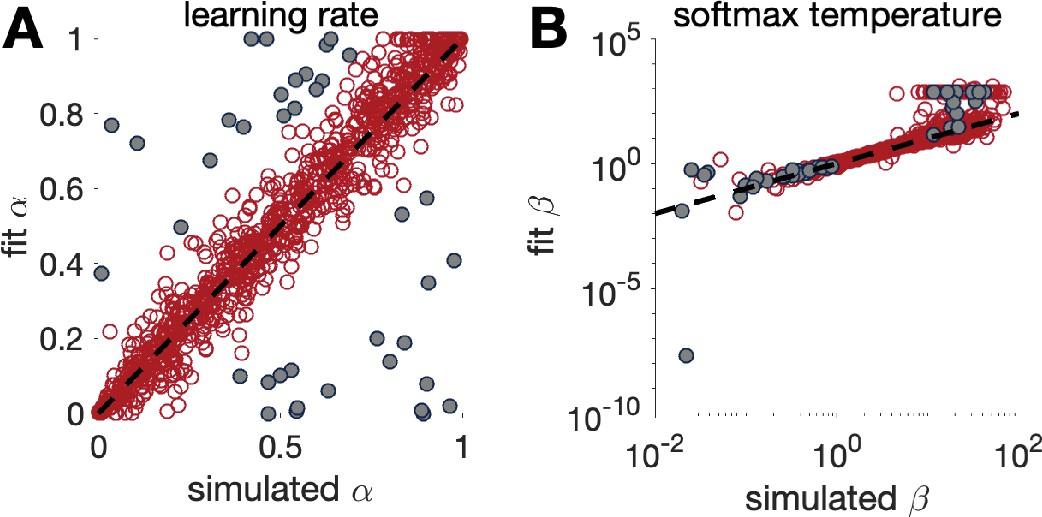

Image from [Wilson and Collins (2019)](https://elifesciences.org/articles/49547)

## Model comparison

### Bayesian Information Criterion (BIC)

Above, you might have noticed a metric "BIC".

When we have multiple models of interest, BIC is one method for penalising the complexity of a model. We want the simplest models, else we run into a risk of overfitting to our data and our results capturing noise. To calculate BIC, we compute the following:

$$BIC = -2 * logLL + k_m log (T)$$

where $k_m$ is the number of parameters in a model and T is the number of trials we have.  The LOWER the BIC, the better the model fit.

Below, we can consider a two learning rate model - one for positive prediction errors and one for negative prediction errors. This adds an additional parameter ($k_m = 3$, two learning rates and softmax temp) relative to the model we originally explored ($k_m = 2$)

In [ ]:
# Two learning rate model

class Agent_TwoLearningRates(object):
  """Agent class

  Parameters
  ----------
  alphaP : float, range (0, 1)
      learning rate for +RPE
  alphaN : float, range (0, 1)
      learning rate for -RPE
  beta  : float, range (0,inf)
      softmax temperature

  """

  # helper function
  softmax = lambda Q, beta: np.exp(beta * Q) / sum(np.exp(beta * Q))


  def __init__(self, env, alphaP, alphaN, beta, q_init=False):
    ''' Initialize our learner '''

    # initialize action space
    self.action_space = np.arange(env.k) + 1
    self.nactions = env.k

    # initialize parameters             <------------ NEW!!!!!!
    self.alphaP = alphaP
    self.alphaN = alphaN
    self.beta = beta

    # initialize Q-values
    if q_init: # check if initial q-values were provided
      # self.q = q_init
      self.q_init = q_init
    else:
      self.q_init = 0

    self.q = np.ones((env.k, ))*q_init
    self.softmax_prob = np.nan

    # track recent experience
    self.action = np.nan
    self.reward = np.nan
    self.RPE = np.nan

  def policy(self):
    ''' Generate a choice according to q-values using the
    softmax function '''

    action_probs = softmax(self.q, self.beta)
    sampled_action = np.random.choice(self.nactions, p=action_probs) + 1

    # track
    self.softmax_prob = action_probs
    self.action = sampled_action

  def policy_forced(self,sampled_action):
    ''' Force a specific action '''

    action_probs = softmax(self.q, self.beta)

    # track
    self.softmax_prob = action_probs
    self.action = sampled_action

  def update(self, reward):
    ''' Update q-value of chosen action according to feedback '''

    action_idx = self.action - 1
    cur_val = self.q[action_idx]

    # track
    self.reward = reward
    self.RPE = reward - cur_val

    # update                                <------------ NEW!!!!!!
    if self.RPE > 0:
      self.q[action_idx] = cur_val + self.alphaP*self.RPE
    else:
      self.q[action_idx] = cur_val + self.alphaN*self.RPE



### EXCERCISE: Model Recovery

Modify the optimizer functions to fit the for two learning rate model to our data.

When you get the gist:
* What do the learning rates of the two learning rate model look like?
* Compare the BIC of best_output (one learning rate) and best_output_TWOALPHAS (two learning rates). Taking into account complexity, which model best fits the data?


In [ ]:
#TODO:

# wrap it up formatted for optimizer
def minimize_me_TWOALPHAS(params, args):

    args_unpack = args[0]

    alpha, beta = params
    env, data = args_unpack

    agent = AgentSolution(env,alpha,beta)
    learnlog = LearningLog(env,agent,ntrials)

    learnlog.fit_data(data)
    return learnlog.NLL()

# run the optimizer
def run_optimizer_TWOALPHAS(env, data):
    arg = (env, data)
    n_inits = 5 # try a few times - local minima
    for i in range(n_inits):
        print("starting iter: ", i, " datetime: ", datetime.datetime.now())

        # random initial guesses
        alpha_init = np.random.random()
        beta_init = random.randint(1,26)

        x0 = [alpha_init,beta_init]
        bounds = ((0, 1), (0, 26))
        opt_output = minimize(minimize_me, x0 = x0, args = [arg],
                                method='L-BFGS-B', bounds = bounds) # method = 'L-BFGS-B'

        # save the winner
        if i == 0:
            best_output = opt_output
        elif opt_output.fun < best_output.fun:
            best_output = opt_output

        print(f'iteration {i} complete')

    print("complete datetime: ", datetime.datetime.now())
    best_output.BIC = len(x0) * np.log(len(participant_data)) + 2*best_output.fun

    return best_output


best_output_TWOALPHAS = run_optimizer(env_twoarm, participant_data)

In [ ]:
# IF YOU NEED HELP (BUT TRY YOURSELF FIRST!)

# wrap it up formatted for optimizer
def minimize_me_TWOALPHAS(params, args):

    args_unpack = args[0]

    alphaP, alphaN, beta = params
    env, data = args_unpack

    agent = Agent_TwoLearningRates(env,alphaP,alphaN,beta)
    learnlog = LearningLog(env,agent,ntrials)

    learnlog.fit_data(data)
    return learnlog.NLL()

# run the optimizer
def run_optimizer_TWOALPHAS(env, data):
    arg = (env, data)
    n_inits = 5 # try a few times - local minima
    for i in range(n_inits):
        print("starting iter: ", i, " datetime: ", datetime.datetime.now())

        # random initial guesses
        alphaP_init = np.random.random()
        alphaN_init = np.random.random()
        beta_init = random.randint(1,26)

        x0 = [alphaP_init,alphaN_init,beta_init]
        bounds = ((0, 1), (0, 1), (0, 26))
        opt_output = minimize(minimize_me_TWOALPHAS, x0 = x0, args = [arg],
                                method='L-BFGS-B', bounds = bounds)

        # save the winner
        if i == 0:
            best_output = opt_output
        elif opt_output.fun < best_output.fun:
            best_output = opt_output

        print(f'iteration {i} complete')

    print("complete datetime: ", datetime.datetime.now())
    best_output.BIC = len(x0) * np.log(len(participant_data)) + 2*best_output.fun

    return best_output


best_output_TWOALPHAS = run_optimizer_TWOALPHAS(env_twoarm, participant_data)

In [ ]:
print(best_output_TWOALPHAS)

## Validation

Finally, when you you have selected your winning model, it is important that it captures the dynamics you care about.

To do this, you can take your parameters from your optimizer and feed them back into your model and simulate the task once more.

In this tutorial, we only looked at choice behavior, so this validation step is less surprising (we see roughly the same amount choice distribution for the validation run vs. the original data).

However, you can use this to ensure your model can account for other summary metrics (e.g. proportion of switching after a negative reward, learning curves aggregated over subjects).

In [ ]:
winning_model_param = AgentSolution(env_twoarm,best_output.x[0],best_output.x[1])
winning_log = LearningLog(env_twoarm,winning_model_param,ntrials)
winning_log.run_simulation()  # run  a new simulation with recovered parameters

log_twoarm.plot_choice_history()
winning_log.plot_choice_history()

# Summary:

## Good coding practices:

* Object oriented programming

## Good Modeling Practices

* Simulation
* Parameter recovery
* Model recovery
* Validation (i.e. predictive checks)

See [Wilson and Collins (2019)](https://elifesciences.org/articles/49547) for more information. To explore these concepts further in code, check out [this rep](https://github.com/christinamaher/10SimpleRulesPythonTutorial/blob/main/03-10simplerules-python.ipynb).

## Advanced methods:

Hierarchical model fitting
* [emfit](https://github.com/mpc-ucl/emfit)
* [cbm](https://payampiray.github.io/cbm)